### Time Series Forecasting

In [1]:
import json
import datetime
import numpy as np 
import pandas as pd 
import pmdarima as pm
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

plt.style.use('seaborn')
rcParams.update({'figure.autolayout': True})

%matplotlib inline



### Load Data

In [2]:
def preprocess_df(df):
    df['date'] = pd.to_datetime(df['date'], infer_datetime_format=True)
    df.index = df['date']
    df.drop(['date', 'status'], inplace=True, axis=1)

    for col in df:
        df[col] = pd.to_numeric(df[col])


with open('data\\states_daily.json') as f:
    data = json.load(f)

confirmed_df = pd.DataFrame(data['confirmed'])
preprocess_df(confirmed_df)

total_confirmed_cases = confirmed_df['tt']
total_confirmed_cases_cum = confirmed_df['tt'].cumsum()

tn_confirmed_cases = confirmed_df['tn']
tn_confirmed_cases_cum = confirmed_df['tn'].cumsum()

print(f'Length of dataset (Number of days): {len(tn_confirmed_cases)}')

Length of dataset (Number of days): 46


### Rolling Average

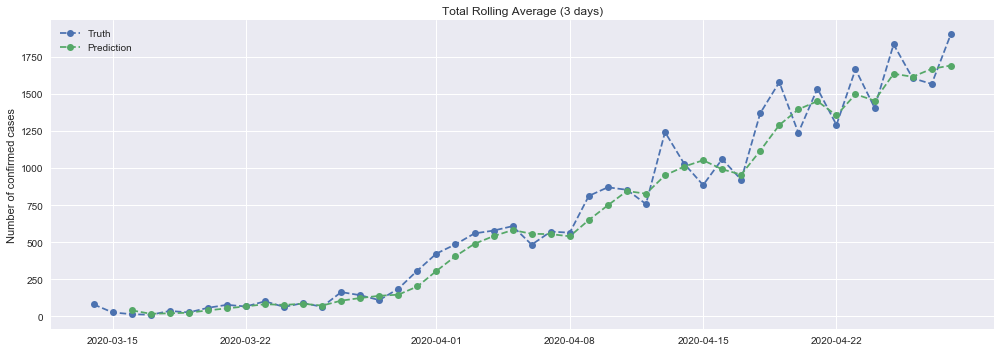

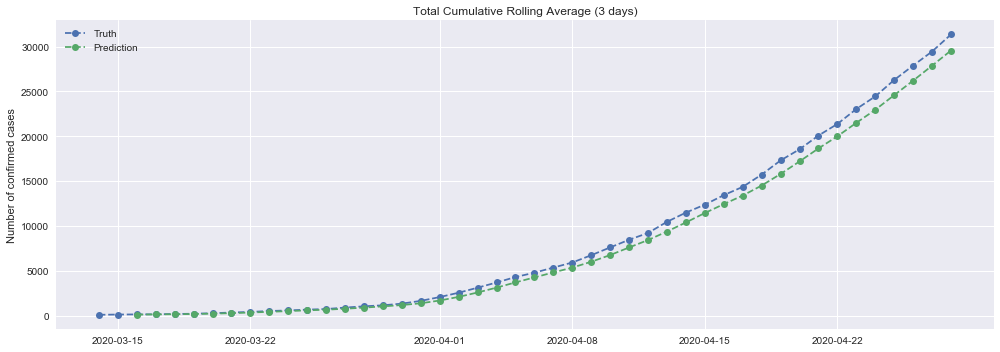

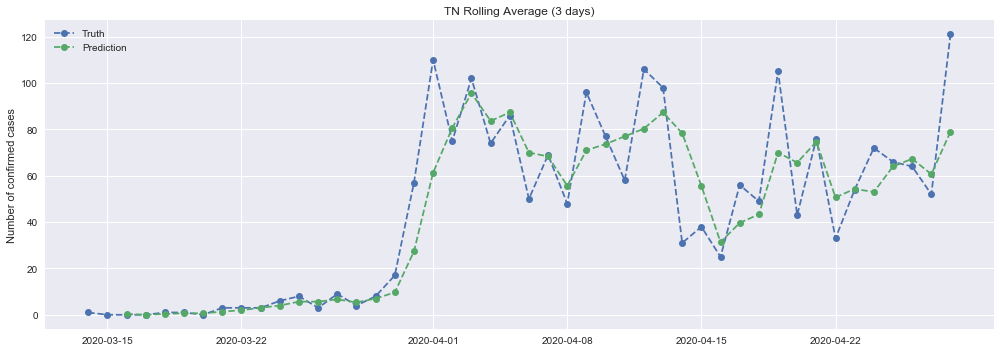

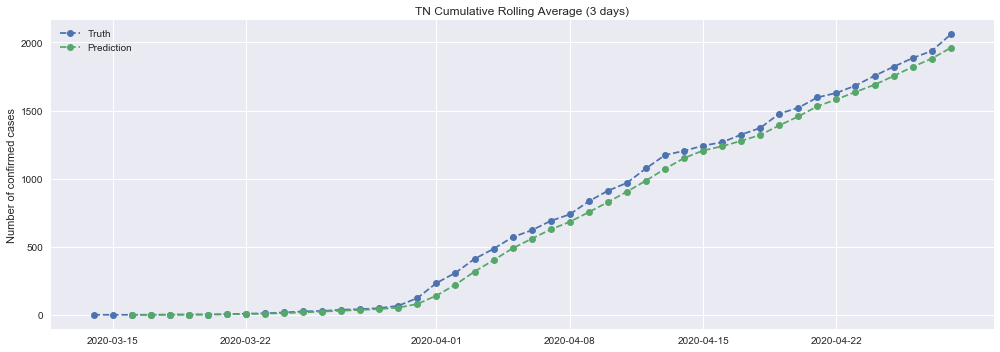

In [3]:
def plot_truth_pred_data(truth, pred, title=''):
    plt.figure(figsize=(14, 5))
    plt.plot(truth.index, truth.values, '--o', label='Truth')
    plt.plot(pred.index, pred.values, '--o', label='Prediction')
    plt.title(title)
    plt.ylabel('Number of confirmed cases')
    plt.legend()
    plt.show()

window = 3

pred_total_confirmed_cases_rm_3 = total_confirmed_cases.rolling(window=window).mean().dropna()
pred_total_confirmed_cases_cum_rm_3 = total_confirmed_cases_cum.rolling(window=window).mean().dropna()
pred_tn_confirmed_cases_rm_3 = tn_confirmed_cases.rolling(window=window).mean().dropna()
pred_tn_confirmed_cases_cum_rm_3 = tn_confirmed_cases_cum.rolling(window=window).mean().dropna()

plot_truth_pred_data(total_confirmed_cases, pred_total_confirmed_cases_rm_3, title=f'Total Rolling Average ({window} days)')
plot_truth_pred_data(total_confirmed_cases_cum, pred_total_confirmed_cases_cum_rm_3, title=f'Total Cumulative Rolling Average ({window} days)')
plot_truth_pred_data(tn_confirmed_cases, pred_tn_confirmed_cases_rm_3, title=f'TN Rolling Average ({window} days)')
plot_truth_pred_data(tn_confirmed_cases_cum, pred_tn_confirmed_cases_cum_rm_3, title=f'TN Cumulative Rolling Average ({window} days)')

### Auto ARIMA

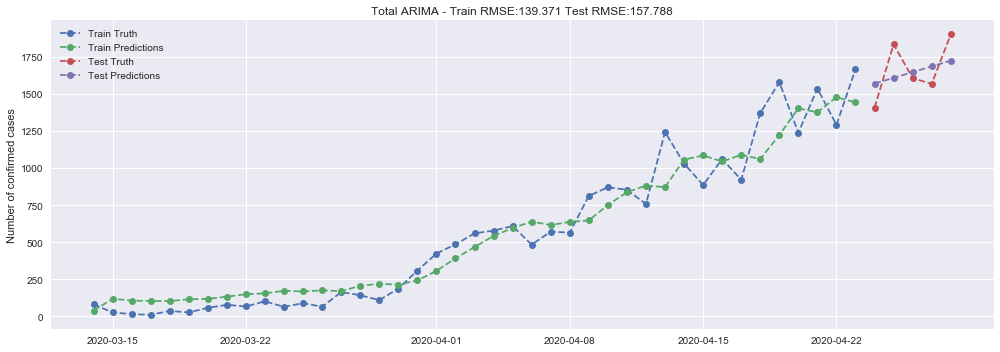

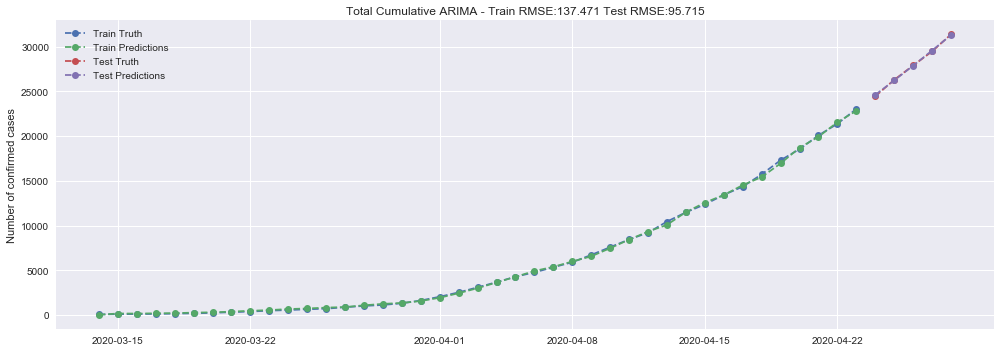

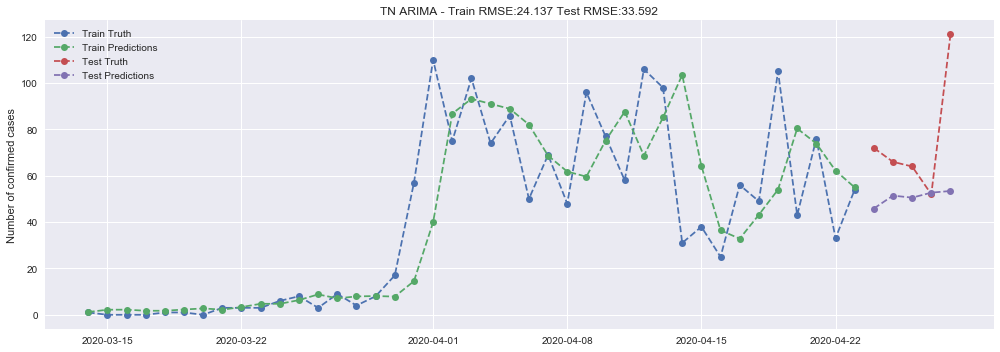

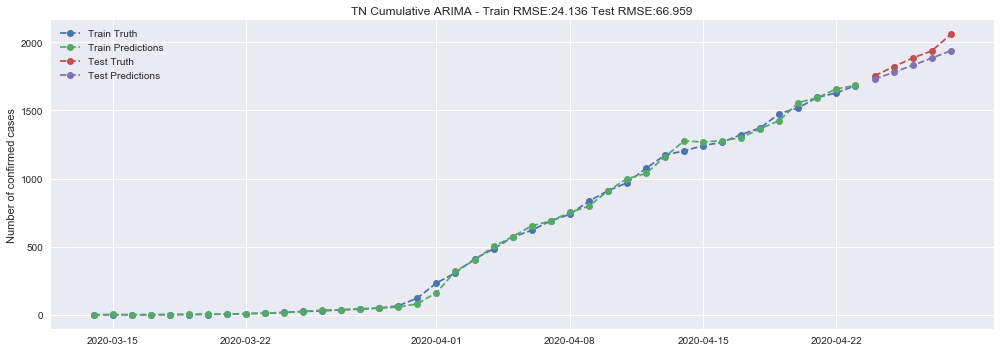

In [4]:
def train_auto_arima_and_plot(series, title=''):

    train, test = train_test_split(series, test_size=0.1, shuffle=False)

    arima_model = pm.auto_arima(train,
                                trace=False,
                                suppress_warnings=True,
                                error_action='ignore')

    train_preds = arima_model.predict_in_sample()
    test_preds = arima_model.predict(n_periods=len(test))

    rmse_train = np.sqrt(mean_squared_error(train.values, train_preds))
    rmse_test = np.sqrt(mean_squared_error(test.values, test_preds))

    plt.figure(figsize=(14, 5))
    plt.plot(train.index, train.values, '--o', label='Train Truth')
    plt.plot(train.index, train_preds, '--o', label='Train Predictions')
    plt.plot(test.index, test.values, '--o', label='Test Truth')
    plt.plot(test.index, test_preds, '--o', label='Test Predictions')
    plt.legend()
    plt.ylabel('Number of confirmed cases')
    plt.title(f'{title} ARIMA - Train RMSE:{rmse_train:.3f} Test RMSE:{rmse_test:.3f}')
    plt.show()
    plt.close()

train_auto_arima_and_plot(total_confirmed_cases, title='Total')
train_auto_arima_and_plot(total_confirmed_cases_cum, title='Total Cumulative')
train_auto_arima_and_plot(tn_confirmed_cases, title='TN')
train_auto_arima_and_plot(tn_confirmed_cases_cum, title='TN Cumulative')

### Test Auto ARIMA

In [5]:
def get_number_of_confirmed_cases_tmr(series, title='', future_days=3):

    arima_model = pm.auto_arima(series,
                                trace=False,
                                suppress_warnings=True,
                                error_action='ignore')
    
    predictions = arima_model.predict(n_periods=future_days)
    dates = [series.index[-1] + datetime.timedelta(days=i) for i in range(1, future_days + 1)]

    print(f'\nType of Prediction: {title}')

    for i in range(future_days):
        print(f"Date: {dates[i].strftime('%Y-%m-%d')} Prediction: {round(predictions[i])}")


get_number_of_confirmed_cases_tmr(total_confirmed_cases, title='Total Confirmed Cases')
get_number_of_confirmed_cases_tmr(total_confirmed_cases_cum, title='Total Confirmed Cases Cumulative')
get_number_of_confirmed_cases_tmr(tn_confirmed_cases, title='TN Confirmed Cases')
get_number_of_confirmed_cases_tmr(tn_confirmed_cases_cum, title='TN Confirmed Cases Cumulative')


Type of Prediction: Total Confirmed Cases
Date: 2020-04-29 Prediction: 1806.0
Date: 2020-04-30 Prediction: 1845.0
Date: 2020-05-01 Prediction: 1885.0

Type of Prediction: Total Confirmed Cases Cumulative
Date: 2020-04-29 Prediction: 33165.0
Date: 2020-04-30 Prediction: 35012.0
Date: 2020-05-01 Prediction: 36901.0

Type of Prediction: TN Confirmed Cases
Date: 2020-04-29 Prediction: 91.0
Date: 2020-04-30 Prediction: 109.0
Date: 2020-05-01 Prediction: 104.0

Type of Prediction: TN Confirmed Cases Cumulative
Date: 2020-04-29 Prediction: 2150.0
Date: 2020-04-30 Prediction: 2259.0
Date: 2020-05-01 Prediction: 2363.0
